In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas
import lsst
pandas.set_option('display.max_rows', 1000)

# from IPython.display import Markdown as md   
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query    
#to get the catalog service
service = lsst.rsp.get_tap_service()
#to get the image service
import lsst.daf.butler as dafButler
repo = '/repo/dc2'  
collection='2.2i/runs/DP0.1'
butler = dafButler.Butler(repo,collections=collection)

In [2]:
#Run this after making an image, to help from running out of space.
import warnings                      # imports the warnings library
import gc                            # imports python's garbage collector
#remove large amounts of data being stored.
def remove_figure(fig):
    """Remove a figure to reduce memory footprint. """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()      # clear the figure
    plt.close(fig) # close the figure
    gc.collect()   # call the garbage collector

In [3]:
# Set up some plotting defaults:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [4]:
#set the location of the cluster core

ra, dec = 55.7506655, -32.2722637

In [34]:
import lsst.geom as geom
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    if skymap is None:
        dataID = {"skymap": "DC2"}
        skymap = butler.get("skyMap", dataID)
    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band, "skymap": 'DC2'}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                               dataId=coaddId)

    return cutout_image

In [35]:
# Select a position at roughly the center of the galaxy cluster:
cutout_image = cutout_coadd(butler, ra, dec, datasetType='deepCoadd',
                            cutoutSideLength=501)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)


The size of the cutout in pixels is:  (501, 501)


In [36]:
# Make a color figure
from astropy.visualization import make_lupton_rgb

In [37]:
def createRGB(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [38]:
from lsst.afw.image import MultibandExposure

cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=1201)
cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=1201)
cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=1201)

# Multiband exposures need a list of images and filters
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

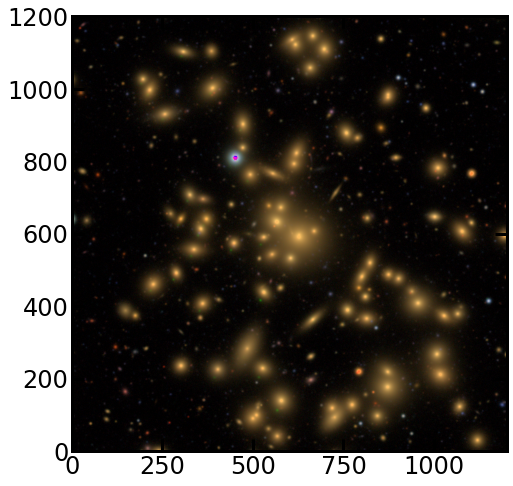

In [39]:
#make a figure with the afw image

rgb_scaled = createRGB(coadds.image, bgr=['g', 'r', 'i'],
                       scale=[0.6, 0.7, 1.0])
plt.imshow(rgb_scaled, origin='lower')

In [40]:
#get the results from the photometric catalog
results = service.search("SELECT ra, dec, mag_u, mag_g, mag_r, mag_i, magerr_u, magerr_g, magerr_r, magerr_i "\
                         "FROM dp01_dc2_catalogs.object "\
                         "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS',  55.7506655, -32.2722637, 1.0)) = 1 "\
                         "AND good = 1 AND clean = 1 AND extendedness = 1"\
                         "AND magerr_u < 0.1 AND magerr_g < 0.1 AND magerr_r < 0.1 AND magerr_i < 0.1"\
                         "AND mag_r < 22", maxrec=20000)
results_tab = results.to_table()
data = results.to_table().to_pandas()

In [41]:
data

,ra,dec,mag_u,mag_g,mag_r,mag_i,magerr_u,magerr_g,magerr_r,magerr_i
0,54.783751,-32.849392,23.569368,22.000187,20.903792,20.468140,0.026222,0.002821,0.001153,0.001271
1,54.823773,-32.852370,24.860800,22.858051,21.339655,20.729740,0.080352,0.005759,0.001620,0.001520
2,54.823891,-32.854650,22.527486,22.466847,21.917771,21.139943,0.010578,0.004181,0.002537,0.002134
3,54.833057,-32.858946,23.241206,21.777041,20.605218,20.173014,0.019904,0.002470,0.000937,0.001004
4,54.831324,-32.858841,23.626334,22.385708,21.275074,20.862729,0.027510,0.003873,0.001512,0.001685
...,...,...,...,...,...,...,...,...,...,...
11607,56.316538,-32.161554,23.409897,22.729427,21.709313,21.343007,0.022960,0.004852,0.002026,0.002470
11608,56.317501,-32.159451,24.052822,23.025156,21.790047,21.251863,0.041216,0.006160,0.002177,0.002275
11609,56.425360,-32.181401,22.459907,22.402853,21.941907,21.311142,0.010761,0.003901,0.002551,0.002395
11610,56.331079,-31.819976,22.370951,21.436566,21.176002,21.078943,0.009548,0.001897,0.001359,0.001901


In [42]:
#get the results from the truth tables
results = service.search("SELECT ra, dec, mag_r, redshift "\
                         "FROM dp01_dc2_catalogs.truth_match "\
                         "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 55.7506655, -32.2722637, 1.0)) = 1 "\
                         "AND mag_r < 22", maxrec=50000)
results_tab = results.to_table()
print(len(results_tab))
truthdata = results.to_table().to_pandas()
truthdata = truthdata[(truthdata['redshift']<0.25) & (truthdata['redshift']>0.15)] #include only galaxies near cluster redshift


36823


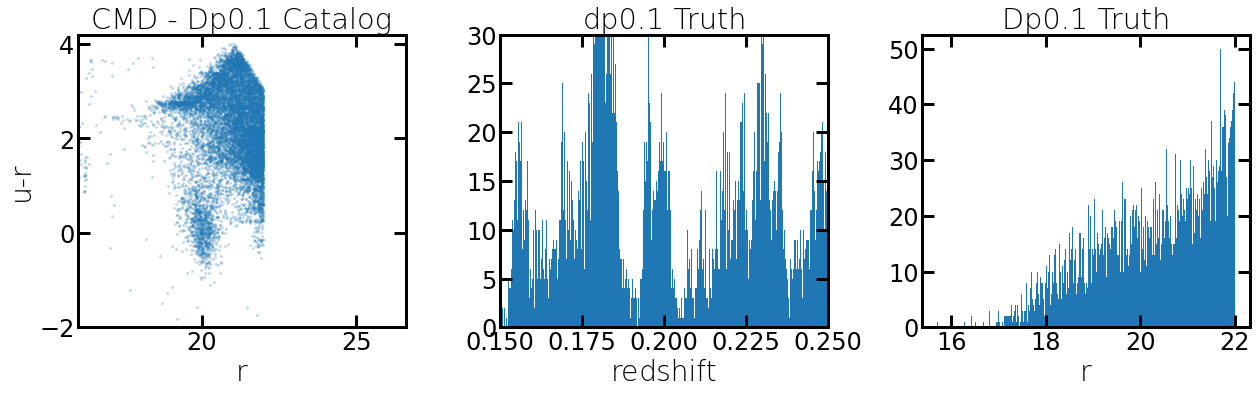

In [43]:
f, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
# Plot the photmetric catalog data as a color-mag diagram. Plot the truth table as r vs. redshift

axes[0].plot(data['mag_r'].values, data['mag_u'].values-data['mag_r'].values,  'o', ms=2, alpha=0.2)
axes[0].set_xlim(16.,26.6)
axes[0].set_ylim(-2,4.2)
axes[0].set_xlabel("r")
axes[0].set_ylabel("u-r")
axes[0].set_title("CMD - Dp0.1 Catalog")

# Plot the truth redshifts
axes[1].hist(truthdata['redshift'].values, bins=400)
axes[1].set_xlim(0.15,0.25)
axes[1].set_ylim(0,30)
axes[1].set_xlabel("redshift")
axes[1].set_title("dp0.1 Truth")

# Plot the truth magnitudes
axes[2].hist(truthdata['mag_r'].values, bins=400)
#axes[2].set_xlim(0.15,0.25)
#axes[2].set_ylim(0,30)
axes[2].set_xlabel("r")
axes[2].set_title("Dp0.1 Truth")

plt.tight_layout()

In [46]:
remove_figure(f)

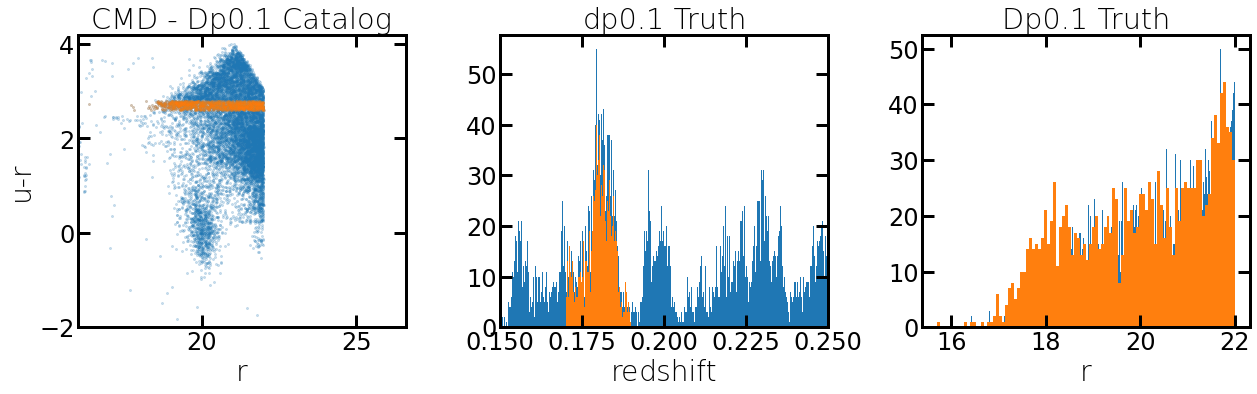

In [47]:
#Select cluster galaxies
#for catalog
#rcsdata = data[(data['mag_r']<22) & ((data['mag_r']-data['mag_i'])<0.45) & ((data['mag_r']-data['mag_i'])>0.3) ]
rcsdata = data[(data['mag_r']<22) & ((data['mag_u']-data['mag_r'])<2.8) & ((data['mag_u']-data['mag_r'])>2.6) ]
#for truth
clustertruthdata = truthdata[(truthdata['redshift']<0.19) & (truthdata['redshift']>0.17) & (truthdata['mag_r']<22)]

f, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
# Plot the photmetric catalog data as a color-mag diagram. Plot the truth table as r vs. redshift

axes[0].plot(data['mag_r'].values, data['mag_u'].values-data['mag_r'].values,  'o', ms=2, alpha=0.2)
axes[0].plot(rcsdata['mag_r'].values, rcsdata['mag_u'].values-rcsdata['mag_r'].values,  'o', ms=2, alpha=0.2)
axes[0].set_xlim(16.,26.6)
axes[0].set_ylim(-2,4.2)
axes[0].set_xlabel("r")
axes[0].set_ylabel("u-r")
axes[0].set_title("CMD - Dp0.1 Catalog")

#Checking out different color-mag plots
#axes[0].plot(data['mag_r'].values, data['mag_r'].values-data['mag_i'].values,  'o', ms=2, alpha=0.2)
#axes[0].plot(rcsdata['mag_r'].values, rcsdata['mag_r'].values-rcsdata['mag_i'].values,  'o', ms=2, alpha=0.2)
#axes[0].set_xlim(16.,26.6)
#axes[0].set_ylim(-1,1.2)
#axes[0].set_xlabel("r")
#axes[0].set_ylabel("r-i")
#axes[0].set_title("CMD - Dp0.1 Catalog")

# Plot the truth redshifts
axes[1].hist(truthdata['redshift'].values, bins=400)
axes[1].hist(clustertruthdata['redshift'].values, bins=100)
axes[1].set_xlim(0.15,0.25)
#axes[1].set_ylim(0,30)
axes[1].set_xlabel("redshift")
axes[1].set_title("dp0.1 Truth")

# Plot the truth magnitudes
axes[2].hist(truthdata['mag_r'].values, bins=400)
axes[2].hist(clustertruthdata['mag_r'].values, bins=100)
#axes[2].set_xlim(0.15,0.25)
#axes[2].set_ylim(0,30)
axes[2].set_xlabel("r")
axes[2].set_title("Dp0.1 Truth")

plt.tight_layout()

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


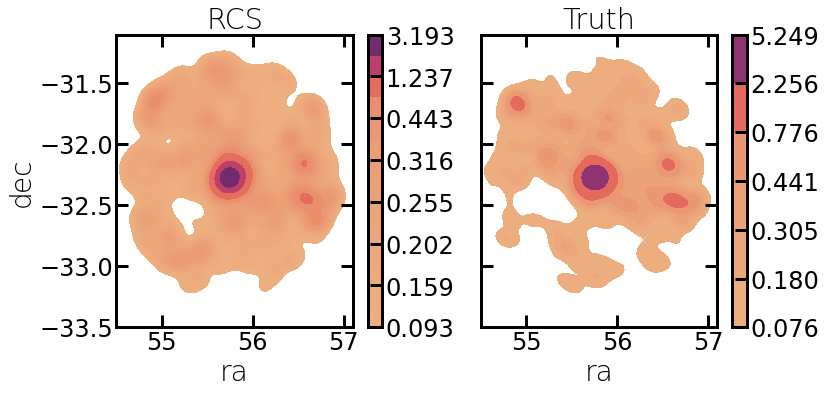

In [48]:
# Set up the matplotlib figure
#use SEABORN functionality to make the kde plot
import seaborn as sns

f, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# Plot a simple histogram with binsize determined automatically
#thres=0.7 removed from both
curveo = sns.kdeplot(rcsdata['ra'], rcsdata['dec'], bw_adjust=0.5, levels=15,fill=True,cmap='flare', ax=axes[0],cbar=True)
axes[0].set_xlim(54.5,57.1)
axes[0].set_ylim(-33.5,-31.1)
axes[0].set_title("RCS")

# Plot a kernel density estimate and rug plot
curvet = sns.kdeplot(clustertruthdata['ra'], clustertruthdata['dec'], bw_adjust=0.5, levels=7,fill=True,cmap='flare', ax=axes[1],cbar=True )
axes[1].set_xlim(54.5,57.1)
axes[1].set_ylim(-33.5,-31.1)
axes[1].set_title("Truth")
#plt.setp(axes, yticks=[])
plt.tight_layout()


In [49]:
remove_figure(f)

In [50]:
#use stats method to build kernel density estimation by hand. Allows more flexibility with the results.

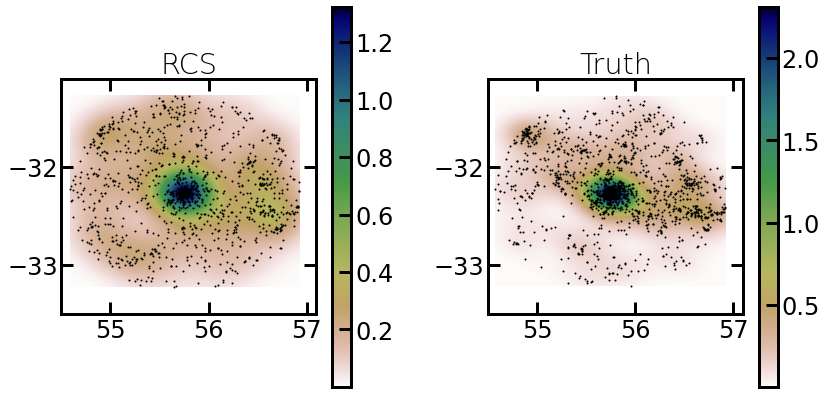

In [51]:
#use stats method to build kde
#plot for RCS

rao = rcsdata['ra']
deco = rcsdata['dec']

from scipy import stats
xmin = rao.min()
xmax = rao.max()
ymin = deco.min()
ymax = deco.max()
#calculate the kde
X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([rao, deco])
kernel = stats.gaussian_kde(values)
oZ = numpy.reshape(kernel(positions).T, X.shape)

#Make the plot for the RCS structures
f, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
# 
ofils=axes[0].imshow(numpy.rot90(oZ), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
axes[0].plot(rao, deco, 'k.', markersize=2)
f.colorbar(ofils, ax=axes[0])
axes[0].set_xlim(54.5,57.1)
axes[0].set_ylim(-33.5,-31.1)
axes[0].set_title("RCS")

# for truth table

rat = clustertruthdata['ra']
dect = clustertruthdata['dec']

xmin = rat.min()
xmax = rat.max()
ymin = dect.min()
ymax = dect.max()
#calculate the kde
X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([rat, dect])
kernel = stats.gaussian_kde(values)
tZ = numpy.reshape(kernel(positions).T, X.shape)

#Make the plot for the Truth table structures

tfils=axes[1].imshow(numpy.rot90(tZ), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
axes[1].plot(rat, dect, 'k.', markersize=2)
f.colorbar(tfils, ax=axes[1])
axes[1].set_xlim(54.5,57.1)
axes[1].set_ylim(-33.5,-31.1)
axes[1].set_title("Truth")
plt.tight_layout()

In [52]:
remove_figure(f)